# HMM Views IC Frontier: Oldest Country ETFs

## 1. Data Fetching

### 1.1 Model configuration

In [3]:
import os
import sys
import datetime as dt
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
import cvxportfolio as cp
import alphamodel as am

config = {'name': 'bl_hmm_sim',
          'universe':
              {'list': ['SPY', 'EWA', 'EWC', 'EWG', 'EWH', 'EWJ', 'EWS', 'EWU', 'EWW'],
               'ticker_col': 'Symbol',
               'risk_free_symbol': 'USDOLLAR'},
          'data':
              {'name': 'eod_returns',
               'source': 'quandl',
               'table': 'EOD',
               'api_key': "6XyApK2BBj_MraQg2TMD"},
          'model':
              {'start_date': '19970102',
               'end_date': '20011231',
               'halflife': 20,
               'min_periods': 3,
               'hidden_states': 2,
               'train_len': 750,
               'data_dir': '/mnt/research_masc/data_store/hmm/',
               'returns':
                   {'sampling_freq': 'daily'},
               'covariance':
                    {'method' : 'FF5',
                     'sampling_freq' : 'monthly',
                     'train_days': 90}
              }
         }

### 1.2 Fetch return data

In [4]:
# Fetch returns / volumes
ss = am.SingleStockHMM(config)
ss.train(force=True)

downloading SPY from 19970102 to 20011231
downloading EWA from 19970102 to 20011231
downloading EWC from 19970102 to 20011231
downloading EWG from 19970102 to 20011231
downloading EWH from 19970102 to 20011231
downloading EWJ from 19970102 to 20011231
downloading EWS from 19970102 to 20011231
downloading EWU from 19970102 to 20011231
downloading EWW from 19970102 to 20011231
downloading USDOLLAR from 19970102 to 20011231
Removing these days from dataset:
            nan price  nan open price  nan close price  nan volumes
1999-04-02          9             NaN              NaN          NaN
2001-09-13          9             NaN              NaN          NaN
2001-09-14          9             NaN              NaN          NaN
          remaining nan price  remaining nan open price  \
SPY                         0                         0   
EWA                         0                         0   
EWC                         0                         0   
EWG                         0    

True

## 2. HMM information coefficient frontier

Hyperparameters:
- hmm_mode: return prediction, 'e' (expectation), 't' (regime over probability threshold)
- preprocess: raw data or exponential decay
- train_len: length of training data
- halflife: halflife of exponential decay

### 2.1 Compute frontier

In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

ic_vs_params = {}

for hmm_mode in ['e', 't']:
    for preprocess in [None, 'exponential']:
        for train_len in range(50, 1501, 50):
            for halflife in [65, 130, 250, 500, 750]:
                # Avoid cases we don't want to run
                if (not preprocess and halflife > 65) or train_len < halflife:
                    continue
                    
                # New run key                
                key = hmm_mode + str(preprocess) + str(train_len) + str(halflife)
                logging.warning('Running for hyperparams {}'.format(key))

                # Set the parameters for the prediction
                ss.cfg['train_len'] = train_len
                ss.cfg['halflife'] = halflife

                # Predict and gather metrics
                ss.predict(mode=hmm_mode, preprocess=preprocess)
                ic = ss.prediction_quality(statistic='information_coefficient', print=False)

                # Save down metrics together with parameters
                ic_vs_params[key] = [hmm_mode, preprocess, train_len, ic.loc[5, 'mean'], ic.loc[5, 'std']]

        # Save down values in .csv
        ic_df = pd.DataFrame.from_dict(ic_vs_params, orient='index')
        ic_df.columns = ['hmm_mode', 'preprocess', 'train_len', 'ic_5d_mean', 'ic_5d_std']
        ic_df.to_csv(ss.cfg['data_dir'] + 'hmm_ic.csv', index=False)

### 2.2 Frontier: expected return, no preprocessing

In [12]:
# library
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
 
# Get the data
data = pd.read_csv(ss.cfg['data_dir'] + 'hmm_ic.csv')
e_raw = data[data.loc[:, 'hmm_mode'] == 'e' & data.loc[:, 'preprocess'] == 'None']
 
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')

# Add a color bar which maps values to colors.
surf=ax.plot_trisurf(e_raw['train_len'], e_raw['halflife'], e_raw['ic_5d_mean'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()
fig

### 2.3 Frontier: expected return, exponential decay

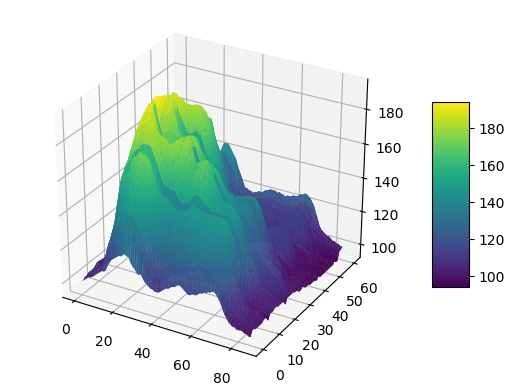

In [13]:
# Get the data
data = pd.read_csv(ss.cfg['data_dir'] + 'hmm_ic.csv')
e_exp = data[data.loc[:, 'hmm_mode'] == 'e' & data.loc[:, 'preprocess'] == 'exponential']
 
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')

# Add a color bar which maps values to colors
surf=ax.plot_trisurf(e_exp['train_len'], e_exp['halflife'], e_exp['ic_5d_mean'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()
fig